In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clean-smt-data/clean_smt_data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import more_itertools as mit
import seaborn as sns
import tensorflow as tf
import json
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model, load_model

import datetime as dt
from datetime import datetime

In [3]:
df = pd.read_csv('../input/clean-smt-data/clean_smt_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387768 entries, 0 to 387767
Data columns (total 58 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        387768 non-null  int64  
 1   Datetime                          387768 non-null  object 
 2   Relative                          387768 non-null  int64  
 3   BellowSoftTouch.SequenceNo        387768 non-null  float64
 4   IO.ToolTemperature                387768 non-null  float64
 5   IO.CurrentVacuumMotor             387768 non-null  float64
 6   Sequence.SoftTouchSequenceNr      387768 non-null  float64
 7   Sequence.SoftTouchActuator        387768 non-null  float64
 8   Sequence.WantedSoleHeight         387768 non-null  float64
 9   CompletedLog.IdleTime             387768 non-null  float64
 10  CompletedLog.TimeToPickPos        387768 non-null  float64
 11  CompletedLog.ToolPickTime         387768 non-null  f

In [4]:
unique = df.nunique()[lambda x: x == 1][0:]
unique = unique.dropna()
print("Columns with only one variable",unique.count())
print("\n")


unique = pd.DataFrame(unique)
unique = unique.T

tore = sorted(unique)
tore

print(f"droping {tore}")

df = df.drop(columns=tore)
df

Columns with only one variable 3


droping ['Alarm.NotFreeBeforePick', 'Alarm.SkirtSensorError', 'Measurement.11']


,Unnamed: 0,Datetime,Relative,BellowSoftTouch.SequenceNo,IO.ToolTemperature,IO.CurrentVacuumMotor,Sequence.SoftTouchSequenceNr,Sequence.SoftTouchActuator,Sequence.WantedSoleHeight,CompletedLog.IdleTime,...,IO.ChangeOverValveON,IO.ChangeOverValveOFF,IO.LiftHeadSensor1NC,IO.LiftHeadSensor2NC,Operation.Setting.0,Alarm.DepositPosNotReady,Alarm.Tool.PositionSkirt,IO.FilterPressure,drops_y,drops
0,0,2019-09-25 07:38:08.318,2554072848,100.0,7952.0,1324.0,100.0,2.0,2709.0,8.0,...,0.0,1.0,1.0,1.0,234.0,0.0,0.0,13808.0,0.0,0.0
1,1,2019-09-25 07:38:08.328,2554082848,100.0,7952.0,1324.0,100.0,2.0,2709.0,8.0,...,0.0,1.0,1.0,1.0,234.0,0.0,0.0,13808.0,0.0,0.0
2,2,2019-09-25 07:38:08.338,2554092848,100.0,7952.0,1324.0,100.0,2.0,2709.0,8.0,...,0.0,1.0,1.0,1.0,234.0,0.0,0.0,13808.0,0.0,0.0
3,3,2019-09-25 07:38:08.348,2554102848,100.0,7952.0,1324.0,100.0,2.0,2709.0,8.0,...,0.0,1.0,1.0,1.0,234.0,0.0,0.0,13808.0,0.0,0.0
4,4,2019-09-25 07:38:08.358,2554112848,100.0,7952.0,1324.0,100.0,2.0,2709.0,8.0,...,0.0,1.0,1.0,1.0,234.0,0.0,0.0,13808.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387763,387763,2019-09-25 14:02:45.948,25631702848,100.0,8360.0,1145.0,100.0,2.0,2474.0,16.0,...,0.0,1.0,1.0,1.0,234.0,0.0,0.0,13840.0,0.0,0.0
387764,387764,2019-09-25 14:02:45.958,25631712848,100.0,8360.0,1145.0,100.0,2.0,2474.0,16.0,...,0.0,1.0,1.0,1.0,234.0,0.0,0.0,13840.0,0.0,0.0
387765,387765,2019-09-25 14:02:45.968,25631722848,100.0,8360.0,1145.0,100.0,2.0,2474.0,16.0,...,0.0,1.0,1.0,1.0,234.0,0.0,0.0,13840.0,0.0,0.0
387766,387766,2019-09-25 14:02:45.978,25631732848,100.0,8360.0,1145.0,100.0,2.0,2474.0,16.0,...,0.0,1.0,1.0,1.0,234.0,0.0,0.0,13840.0,0.0,0.0


In [5]:
print("get all the root words for the headers")

headers = sorted(df)
hed = {'co':headers}
df_h = pd.DataFrame(hed)
sp_cols = df_h['co'].str.split('.',expand=True)
sp_cols['root'] = sp_cols[0]
clm = pd.DataFrame(sp_cols.root.value_counts())
clm = clm.reset_index()
clm = clm[clm['root']>1]
grp = clm['index'].to_list()
grps=[]
for i in grp:
    i =i + "."
    grps.append(i)
grps


print('Get all the headers that contain the root word')
obj= {}
for i in grps:
    obj[str(i)] = [
    col for col in df.columns
    if i in col]
    
print('pad all the column header lists to have the same number of words')  
def pad_dict_list(dict_list, padel):
    lmax = 0
    for lname in dict_list.keys():
        lmax = max(lmax, len(dict_list[lname]))
    for lname in dict_list.keys():
        ll = len(dict_list[lname])
        if  ll < lmax:
            dict_list[lname] += [padel] * (lmax - ll)
    return dict_list


padded_list = pad_dict_list(obj,"empty")
columns = pd.DataFrame(padded_list)


print('add "drops" and "datetime" columns')
cs = len(columns.columns)
words =["drops","Datetime"]
ncl = []
ncv = []


for v in words:
    for i in range(cs):
        if v == words[0]:
            ncl.append(v)
        else:
            ncv.append(v)

lx = len(columns.index)+1
nx = lx+1
columns.loc[lx] = np.array(ncl)
columns.loc[nx] = np.array(ncv)


print('Create a dictionary containing all the dataframes')
d = {}
items = grps
number = 1
for i in grps:
    new_df = columns[columns[i]!="empty"]
    vals = new_df[i].to_list()
    d[i] = pd.DataFrame(df,columns=vals)
    number = number + 1 

get all the root words for the headers
Get all the headers that contain the root word
pad all the column header lists to have the same number of words
add "drops" and "datetime" columns
Create a dictionary containing all the dataframes


In [6]:

mc = [col for col in df.columns if 'Measurement' in col]
df = df.drop(columns=mc)
df = df.drop(columns=['Unnamed: 0','drops_y'])

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Relative,387768.0,1.151737e+10,5.836469e+09,2.554073e+09,7.663490e+09,1.235291e+10,1.542233e+10,2.563174e+10
BellowSoftTouch.SequenceNo,387768.0,1.040677e+02,4.199470e+00,1.000000e+02,1.000000e+02,1.050000e+02,1.060000e+02,1.170000e+02
IO.ToolTemperature,387768.0,8.322963e+03,1.682655e+02,7.928000e+03,8.216000e+03,8.352000e+03,8.456000e+03,8.592000e+03
IO.CurrentVacuumMotor,387768.0,1.393454e+03,6.035473e+02,0.000000e+00,1.164000e+03,1.286000e+03,1.433000e+03,4.633000e+03
Sequence.SoftTouchSequenceNr,387768.0,1.040677e+02,4.199470e+00,1.000000e+02,1.000000e+02,1.050000e+02,1.060000e+02,1.170000e+02
Sequence.SoftTouchActuator,387768.0,2.224201e+00,6.309810e-01,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00
Sequence.WantedSoleHeight,387768.0,1.565439e+03,8.299860e+02,1.900000e+02,8.940000e+02,1.476000e+03,2.395000e+03,2.714000e+03
CompletedLog.IdleTime,387768.0,8.072465e+03,2.698047e+04,7.000000e+00,1.600000e+01,1.700000e+01,5.532000e+03,1.859540e+05
CompletedLog.TimeToPickPos,387768.0,9.869218e+03,1.851874e+03,5.558000e+03,8.556000e+03,1.003700e+04,1.107300e+04,1.479000e+04
CompletedLog.ToolPickTime,387768.0,5.004372e+03,1.322826e+03,1.383000e+03,3.984000e+03,4.406000e+03,6.049000e+03,7.893000e+03


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:xlabel='Datetime'>

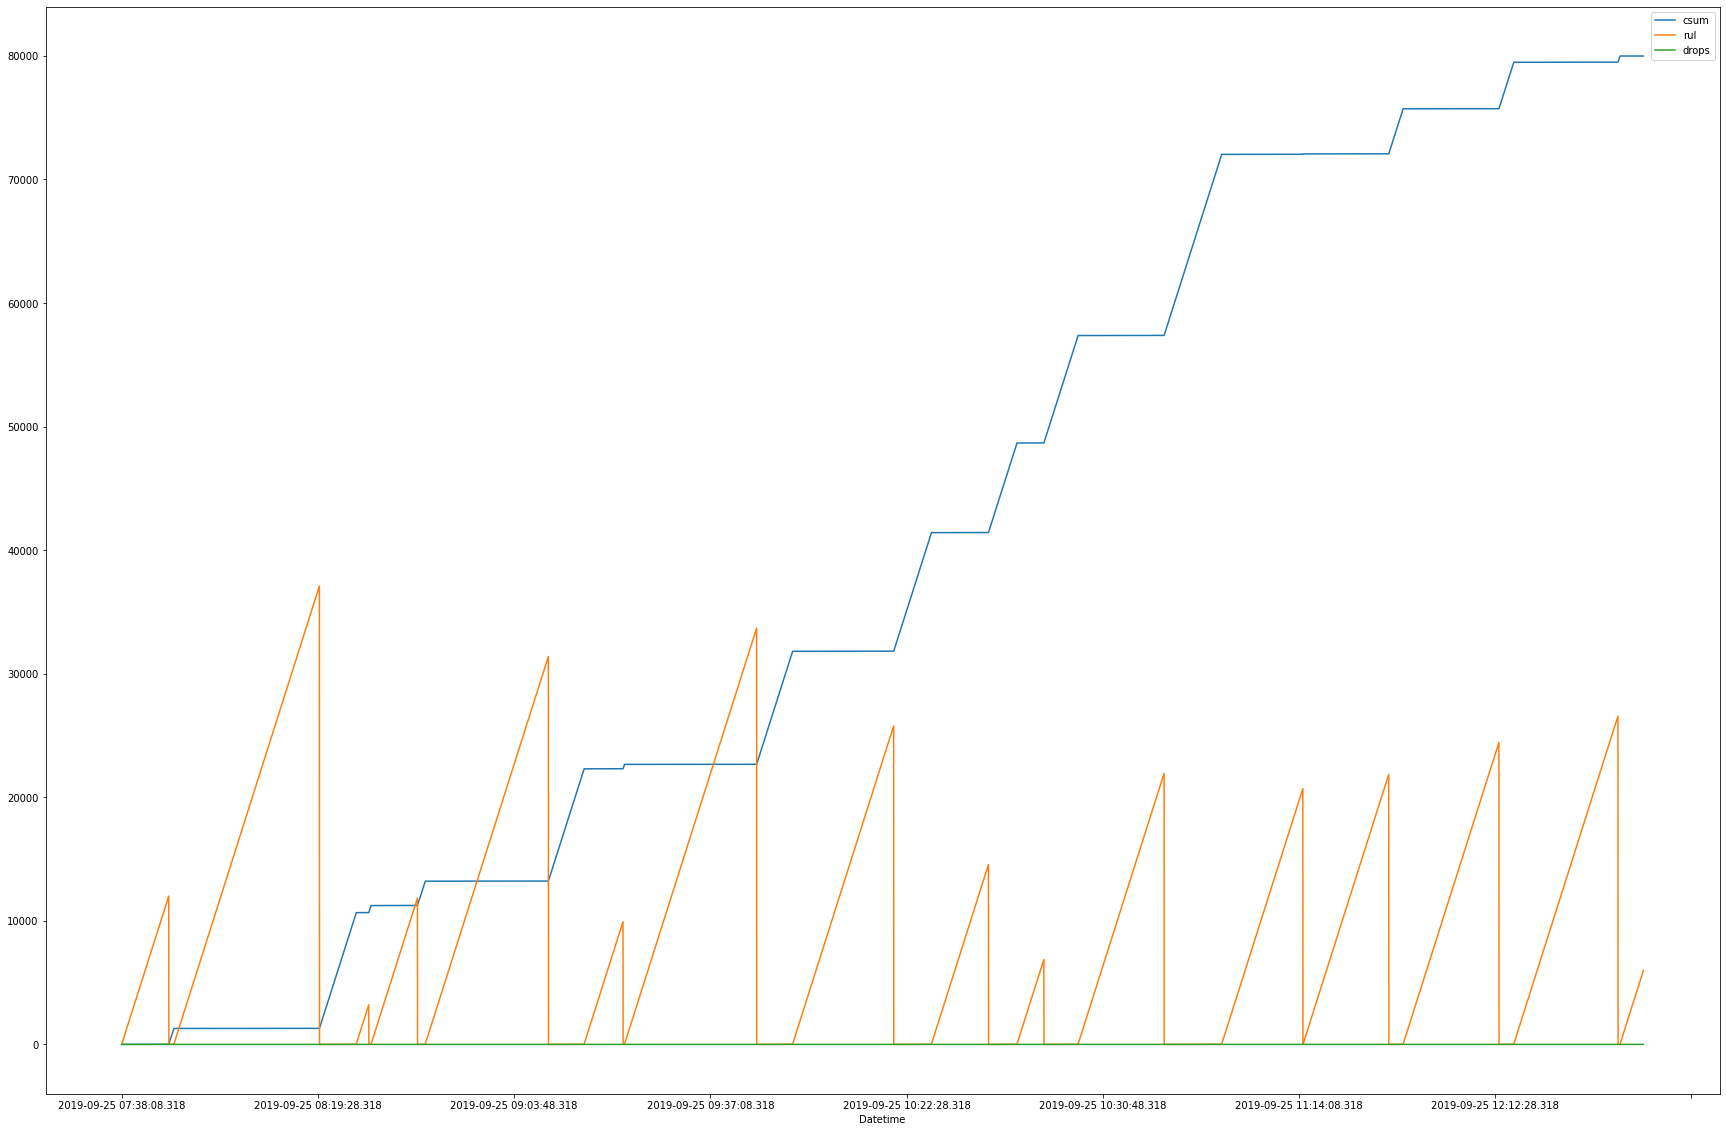

In [8]:
ct = df[['Datetime','drops']]
x1 = ct['drops'].to_list()

x = 0 #pd.to_numeric(x)

rr = []
for r in x1:
    if r == 0:
        x += 1
        rr.append(x)
    else:
        x=0
        rr.append(x)
        

        
ct['rul'] = rr
ct['csum'] = ct['drops'].cumsum()
plds = ct[['Datetime','csum','rul','drops']]

plds.plot(x='Datetime',figsize=(30,20))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:>

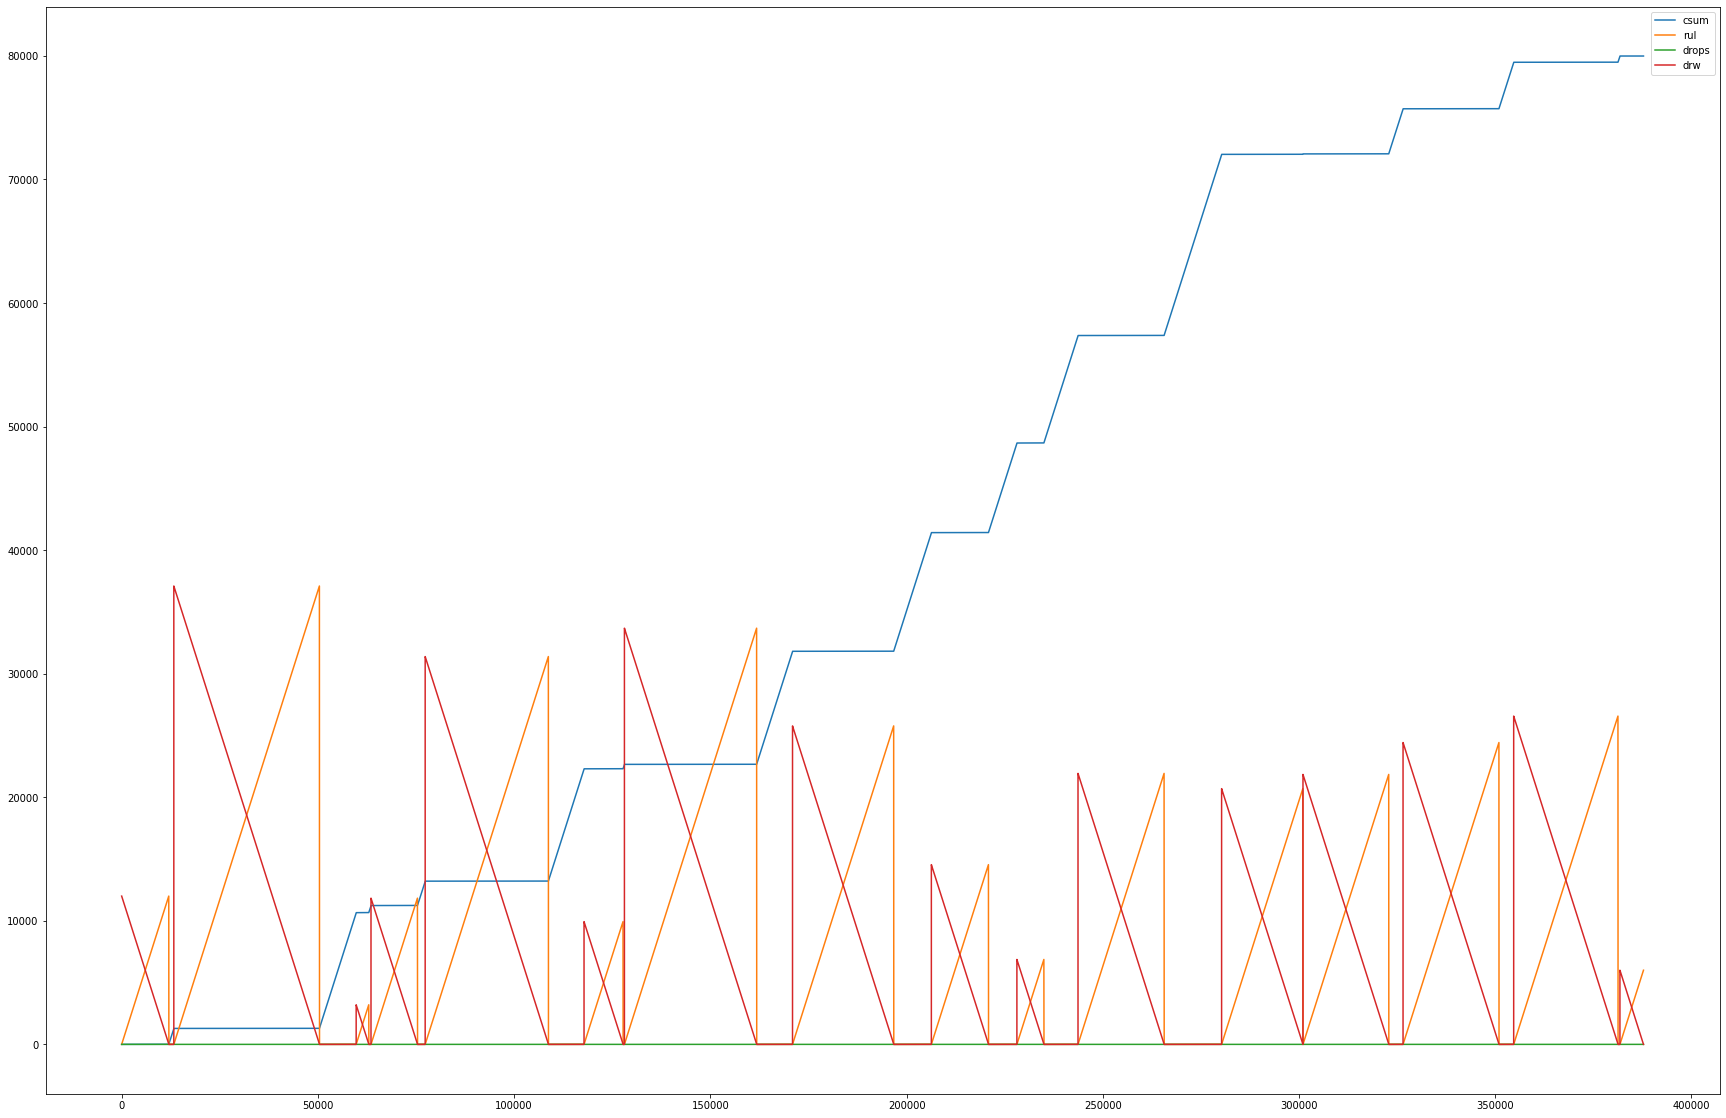

In [9]:
fr = plds[plds['drops']==1]
fi = pd.to_numeric(fr.index.to_list())
fi = fi.astype(int)
sre = fi[0]
fi =  np.append([0],fi)
nu = len(plds)
fi = np.append(arr=fi,axis=nu,values=nu)


dfs = fi
x = 0 
drw = []
for e in dfs:
    for a in plds['rul']:
        x += 1
        fvy = -abs(x) + e
        drw.append(fvy)
        if fvy < 0:
            break
        else:
            continue
drw.pop(0)
plds['drw'] =drw
plds.plot(figsize=(30,20))

MinMaxScaler()
[1.5200e+02 9.7000e+01 1.0034e+04 9.9680e+03 1.3000e+02 1.0000e+00]


<AxesSubplot:>

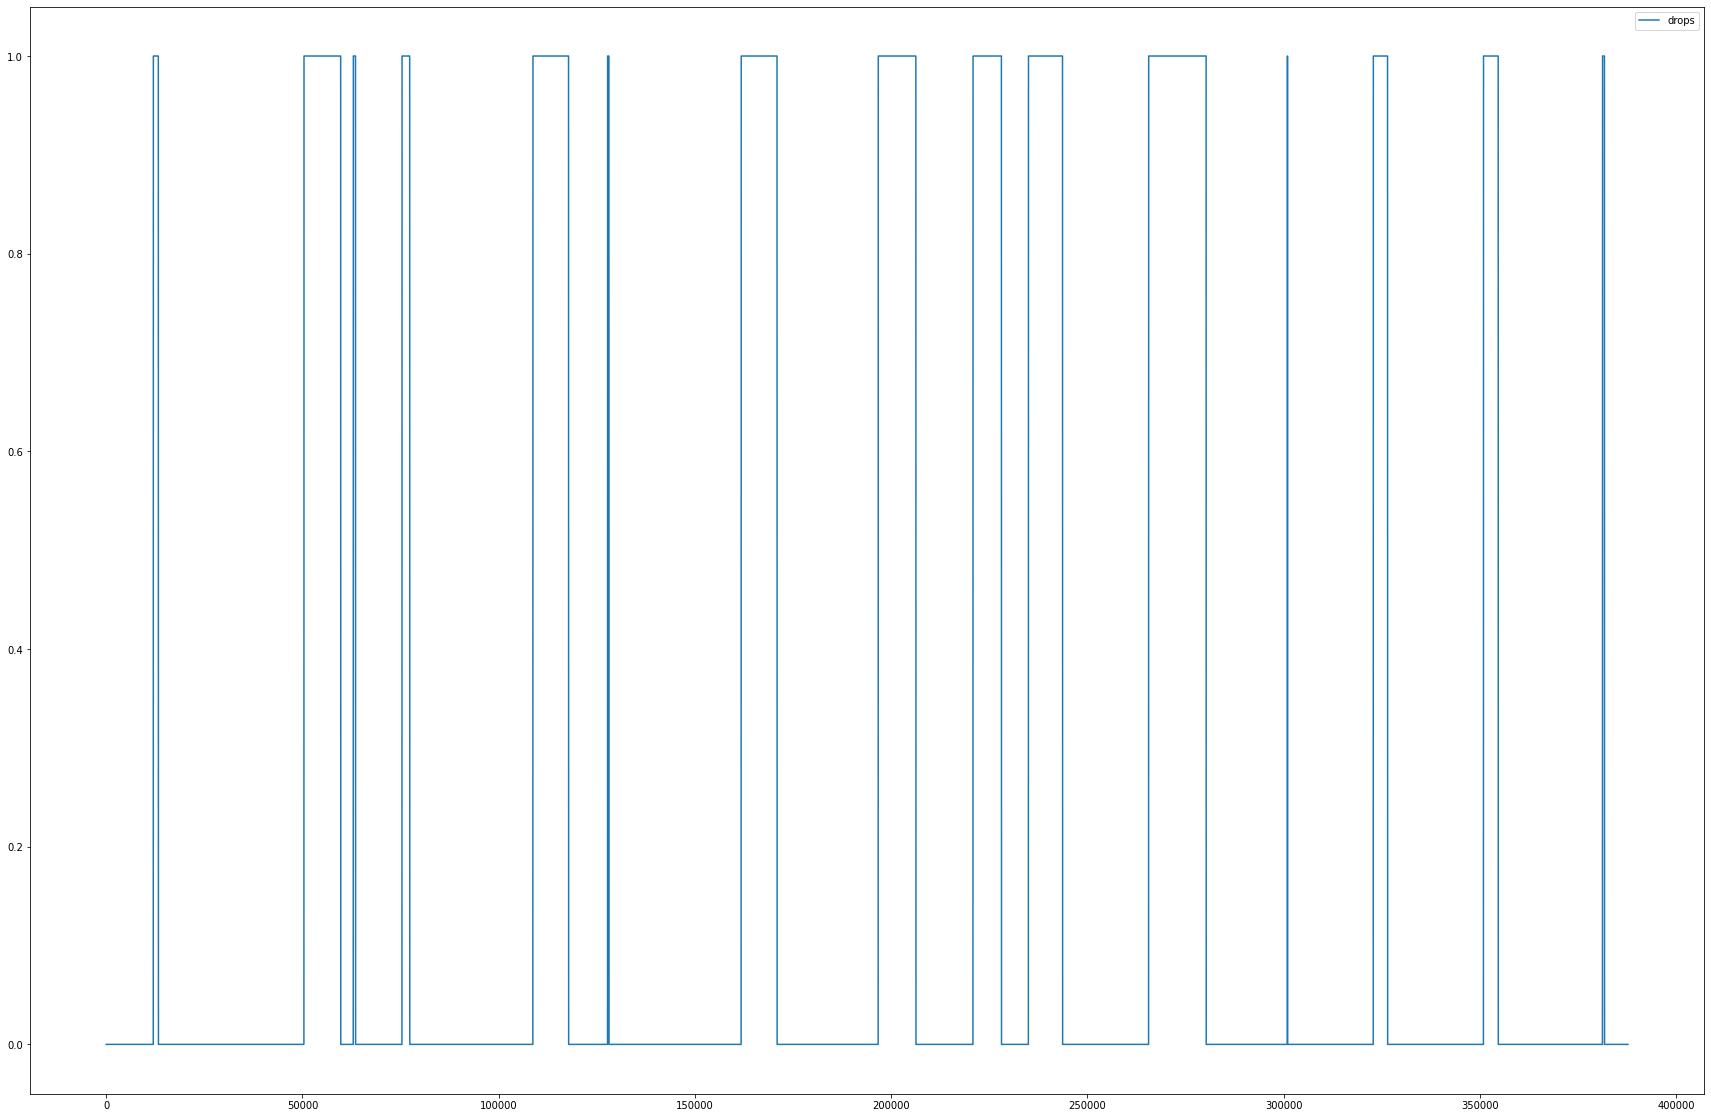

In [10]:
from sklearn.preprocessing import MinMaxScaler

complog2 = d['Actuator.']
complog2 = complog2.drop(columns=['Datetime'])
data = complog2.values
scaler = MinMaxScaler()
print(scaler.fit(data))


print(scaler.data_max_)

vals = scaler.transform(data)
heads = sorted(complog2)
vals
df_r = pd.DataFrame(vals,columns=heads)
df_r = df_r.drop(columns=['Actuator.CurrentPos','Actuator.TargetPos','Actuator.CurrentSpeed','Actuator.CurrentForce','Actuator.WantedBellowPressure'])
df_r.plot(figsize=(30,20))

In [11]:
yes=['CompletedLog.ToolDepositTime','CompletedLog.IdleTime','CompletedLog.TimeDepositNotReady','Status.ElementStatus',
 'Status.MachineStatus','VibrationValue','BellowSoftTouch.AdjustStep','BellowSoftTouch.iWantedDest','Sequence.WantedSoleHeight','Actuator.WantedBellowPressure',
'Datetime',
 'IO.BellowPressure',
 'IO.ChangeOverValveOFF',
 'IO.ChangeOverValveON',
 'IO.CurrentVacuumMotor',
 'IO.FilterPressure',
 'IO.LiftHeadSensor1NC',
 'IO.LiftHeadSensor2NC',
 'IO.RakeForcedVacuumOFF',
 'IO.RakeForcedVacuumON',
 'IO.SoleVacuum',
 'IO.SpeedVacuumMotor',
 'IO.ToolTemperature',
 'IO.VacuumValveOFF',
 'IO.VacuumValveON',
 'drops']
#no=['CompletedLog.ToolPickTime','CompletedLog.TimeToDepositPos','CompletedLog.TotalCycleTime']
#maybe = ['Statistics.RT_VacuumBlower','Statistics.RT_BellowBlower','Sequence.SoftTouchActuator']

dff = pd.DataFrame(df,columns=yes)
dff

,CompletedLog.ToolDepositTime,CompletedLog.IdleTime,CompletedLog.TimeDepositNotReady,Status.ElementStatus,Status.MachineStatus,VibrationValue,BellowSoftTouch.AdjustStep,BellowSoftTouch.iWantedDest,Sequence.WantedSoleHeight,Actuator.WantedBellowPressure,...,IO.LiftHeadSensor1NC,IO.LiftHeadSensor2NC,IO.RakeForcedVacuumOFF,IO.RakeForcedVacuumON,IO.SoleVacuum,IO.SpeedVacuumMotor,IO.ToolTemperature,IO.VacuumValveOFF,IO.VacuumValveON,drops
0,2302.0,8.0,900.0,2.0,4.0,2.0,10.0,9729.0,2709.0,120.0,...,1.0,1.0,1.0,0.0,13776.0,474.0,7952.0,1.0,0.0,0.0
1,2302.0,8.0,900.0,2.0,4.0,2.0,10.0,9729.0,2709.0,120.0,...,1.0,1.0,1.0,0.0,13776.0,474.0,7952.0,1.0,0.0,0.0
2,2302.0,8.0,900.0,2.0,4.0,2.0,10.0,9729.0,2709.0,120.0,...,1.0,1.0,1.0,0.0,13776.0,474.0,7952.0,1.0,0.0,0.0
3,2302.0,8.0,900.0,2.0,4.0,2.0,10.0,9729.0,2709.0,120.0,...,1.0,1.0,1.0,0.0,13776.0,474.0,7952.0,1.0,0.0,0.0
4,2302.0,8.0,900.0,2.0,4.0,2.0,10.0,9729.0,2709.0,120.0,...,1.0,1.0,1.0,0.0,13776.0,474.0,7952.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387763,2297.0,16.0,2864.0,4.0,5.0,2.0,10.0,9205.0,2474.0,50.0,...,1.0,1.0,1.0,0.0,13776.0,396.0,8360.0,1.0,0.0,0.0
387764,2297.0,16.0,2864.0,4.0,5.0,2.0,10.0,9205.0,2474.0,50.0,...,1.0,1.0,1.0,0.0,13776.0,396.0,8360.0,1.0,0.0,0.0
387765,2297.0,16.0,2864.0,4.0,5.0,2.0,10.0,9205.0,2474.0,50.0,...,1.0,1.0,1.0,0.0,13776.0,396.0,8360.0,1.0,0.0,0.0
387766,2297.0,16.0,2864.0,4.0,5.0,2.0,10.0,9205.0,2474.0,50.0,...,1.0,1.0,1.0,0.0,13776.0,396.0,8360.0,1.0,0.0,0.0


In [12]:
df2 = plds[['csum', 'rul','drw','drops']]
dff['Datetime'] = pd.to_datetime(df['Datetime'])
dfm = dff.drop(columns=['drops'])

df3 = pd.merge(dfm,df2, left_index=True, right_index=True)



In [13]:

df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387768 entries, 0 to 387767
Data columns (total 29 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   CompletedLog.ToolDepositTime      387768 non-null  float64       
 1   CompletedLog.IdleTime             387768 non-null  float64       
 2   CompletedLog.TimeDepositNotReady  387768 non-null  float64       
 3   Status.ElementStatus              387768 non-null  float64       
 4   Status.MachineStatus              387768 non-null  float64       
 5   VibrationValue                    387768 non-null  float64       
 6   BellowSoftTouch.AdjustStep        387768 non-null  float64       
 7   BellowSoftTouch.iWantedDest       387768 non-null  float64       
 8   Sequence.WantedSoleHeight         387768 non-null  float64       
 9   Actuator.WantedBellowPressure     387768 non-null  float64       
 10  Datetime                        

In [16]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
dfx = df3[df3.columns.difference(['drops'])]
dfx = dfx[dfx.columns.difference(['Datetime'])]

#df3 = pd.to_numeric(df3)
#dfx = np.array(dfx, dtype=float)
X = dfx
vif = calc_vif(X)
vif1 = vif.dropna()
vif1 = vif.sort_values(by='VIF')
vif1 = vif1.reset_index(drop=True)
#format vif result
format_vif = {
    'Individual % of total': '{:.1%}'
}
vif1.style.format(format_vif)

,variables,VIF
0,CompletedLog.IdleTime,1.192183
1,CompletedLog.TimeDepositNotReady,1.335755
2,drw,3.048015
3,rul,3.525409
4,csum,3.899125
5,Sequence.WantedSoleHeight,7.550155
6,Status.MachineStatus,7.591704
7,VibrationValue,8.024164
8,IO.CurrentVacuumMotor,11.111452
9,BellowSoftTouch.AdjustStep,13.003919


In [20]:
cor = dff.drop(columns=['Datetime'])
cor.insert(0, 'drops', cor.pop('drops'))
cor1 = cor.corr().sort_values(by='drops',ascending=False)
#cor1 = cor1[cor1['drops']>0]
#cor1
cor1

,drops,CompletedLog.ToolDepositTime,CompletedLog.IdleTime,CompletedLog.TimeDepositNotReady,Status.ElementStatus,Status.MachineStatus,VibrationValue,BellowSoftTouch.AdjustStep,BellowSoftTouch.iWantedDest,Sequence.WantedSoleHeight,...,IO.FilterPressure,IO.LiftHeadSensor1NC,IO.LiftHeadSensor2NC,IO.RakeForcedVacuumOFF,IO.RakeForcedVacuumON,IO.SoleVacuum,IO.SpeedVacuumMotor,IO.ToolTemperature,IO.VacuumValveOFF,IO.VacuumValveON
drops,1.000000,-0.031620,0.094258,-0.170338,0.585390,-0.396638,-0.211446,0.383621,-0.408376,0.212086,...,-0.079639,0.094926,0.096357,-0.516632,0.541180,-0.488385,-0.029450,0.039260,-0.526918,0.550124
Status.ElementStatus,0.585390,0.080662,-0.007230,0.064282,1.000000,-0.123481,-0.004951,0.387642,-0.170316,-0.258219,...,0.184114,-0.005333,-0.005482,-0.563681,0.567251,-0.515878,0.294882,0.255675,-0.597407,0.598088
IO.VacuumValveON,0.550124,0.020979,0.026591,-0.016477,0.598088,-0.108954,-0.092451,0.410529,-0.168912,-0.002444,...,0.040909,0.055919,0.054097,-0.855114,0.886057,-0.756372,0.112861,0.115074,-0.957817,1.000000
IO.RakeForcedVacuumON,0.541180,-0.152333,0.008667,0.002320,0.567251,-0.086595,-0.308345,0.448692,-0.280048,0.027169,...,-0.003814,0.133790,0.130522,-0.957850,1.000000,-0.548145,-0.006146,0.096177,-0.876928,0.886057
IO.ChangeOverValveON,0.470380,0.029372,0.009255,-0.001500,0.579796,-0.070301,-0.098695,0.505526,-0.123661,-0.045923,...,0.064687,-0.045197,-0.044776,-0.832124,0.799680,-0.684410,0.127671,0.124174,-0.892699,0.855042
BellowSoftTouch.AdjustStep,0.383621,-0.077236,0.021753,-0.044090,0.387642,-0.068900,-0.178725,1.000000,-0.294784,0.051091,...,-0.029490,0.012087,0.014110,-0.520900,0.448692,-0.385643,0.001334,0.042084,-0.478871,0.410529
IO.BellowPressure,0.221196,0.166409,-0.015135,0.045107,0.366345,-0.031444,0.069349,0.213777,0.160985,-0.122807,...,0.110319,-0.080896,-0.083793,-0.623919,0.624073,-0.590934,0.133401,0.107184,-0.788853,0.777563
Sequence.WantedSoleHeight,0.212086,-0.077575,0.087826,-0.081126,-0.258219,-0.189404,-0.167491,0.051091,-0.304772,1.000000,...,-0.056131,0.249607,0.252259,-0.008979,0.027169,-0.081877,-0.355472,-0.019980,0.020766,-0.002444
IO.LiftHeadSensor2NC,0.096357,0.038407,0.040086,0.005771,-0.005482,-0.044661,-0.030006,0.014110,-0.206356,0.252259,...,-0.011245,0.985154,1.000000,-0.104132,0.130522,-0.134483,-0.113398,0.005525,-0.023751,0.054097
IO.LiftHeadSensor1NC,0.094926,0.037464,0.039826,0.007026,-0.005333,-0.042733,-0.030180,0.012087,-0.203443,0.249607,...,-0.009246,1.000000,0.985154,-0.106789,0.133790,-0.132394,-0.111712,0.008267,-0.024910,0.055919


<AxesSubplot:>

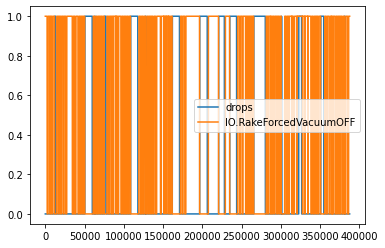

In [26]:
ssdr = dff[['drops','IO.RakeForcedVacuumOFF']]
ssdr.plot()